# Comparison of the CNN models based on 5-fold cross-validation

User c is completely removed as this is the test set.

The remaining users A,B,D,E and F make up each fold.

For example, fold 1 will train on users B,D,E and F then evaluate on A (and so on for each fold).

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [1]:
# Plot graphs inline
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms/3/'

RESULTS_PATH = BASE_PATH + 'results/CNN_model_comparison/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

Import remaining packages

In [3]:
import numpy as np
from keras.optimizers import SGD
from keras.utils import np_utils
import pickle
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [4]:
SAVE_GRAPHS_OVERFITTING = False  # false to not override results
SAVE_GRAPHS_AVERAGES = False  # save avg acc and avg loss graphs from k fold
SAVE_GRAPHS_DISTRIBUTIONS = False  # save accuracy distribution across folds graphs

SAVE_RESULTS_OVERFITTING = False  # false to not override results
SAVE_RESULTS_K_FOLD = False
SAVE_BOXPLOTS = True

In [5]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)
batch_size = 64

# input image dimensions
img_rows, img_cols = 75, 75
# user c excluded as this is reserved for final evaluation
users = ["A", "B", "D", "E", "F"] 

In [6]:
def load_data(user_letter):
    """
    load the data and labels associated with a particular user/subject (interchangeable)
    :param user_letter: Letter representing subject/user (A-F)
    :type user_letter: str
    :return: data and labels
    :rtype: tuple of the form (data, labels)
    """
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))

    return data, labels

In [7]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

In [8]:
def split_train_validation(validation_user):
    """
    Splits the data into a train and validation set.
    The validation set is composed of the subject specified, the training set of the remaining subjects.
    :param validation_user: Subject to use for validation set (A-F)
    :type validation_user: str
    :return: data and labels for the train and validation set
    :rtype: dictionary with keys "train_data", "train_labels", "validation_data" and "validation_labels"
    """
    train_data = None
    train_labels = None
    first_round = True
    validation_data = []
    validation_labels = []
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]

        if user == validation_user:
            validation_data = data
            validation_labels = labels
            
        else:
            if first_round:
                train_data = data
                train_labels = labels
                first_round = False
            else:
                train_data = np.concatenate((train_data, data))
                train_labels = np.concatenate((train_labels, labels))

    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    train_data = train_data.astype('float32')
    validation_data = validation_data.astype('float32')
    train_data /= 255
    validation_data /= 255 
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels
       }

## Define Models

In [9]:
def make_model(nb_filters, img_rows, img_cols, nb_classes):
    """
    Make and return the CNN model
    :param nb_filters: Number of filters to use in layers 1,2 and 3,4 respectively
    :type nb_filters: str containing the number of filters for the first two layers followed by 
    the last two layers, for example: "16-32"
    :param img_rows: image height
    :type img_rows: int
    :param img_cols: image width
    :type img_cols: int
    :param nb_classes: Number of classes to be predicted
    :type nb_classes: int
    :return: CNN model
    :rtype: Keras sequential model
    """
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, (3, 3), padding='same', input_shape=(1, img_rows, img_cols), activation='relu'))
    model.add(Convolution2D(size_1, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(size_2, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(size_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

In [6]:
model_types = ["2-4", "4-8", "8-16", "16-32", "32-64", "64-128"]

## Examining Overfitting
Train each model on 4 of the 5 users then evalaute on the 5th.

Compare at which epoch the models begin to overfit.

In [11]:
nb_epoch = 50

In [12]:
overfitting_results = {}
validation_user = "B"  # use user B for validation

In [0]:
for model_type in model_types:
    print("Model:", model_type)
    data_split = split_train_validation(validation_user)
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    model = make_model(model_type, img_rows, img_cols, nb_classes)
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        train_labels,
        batch_size=batch_size,
        epochs=nb_epoch,
        shuffle=True, 
        validation_data=(validation_data, validation_labels),
        verbose=0)
    overfitting_results[model_type] = history.history

Model: 2-4
Model: 4-8
Model: 8-16
Model: 16-32
Model: 32-64
Model: 64-128


### Save Results

In [0]:
if SAVE_RESULTS_OVERFITTING:
    with open(RESULTS_PATH + "overfitting_results.pkl", 'wb') as results_file:
        pickle.dump(overfitting_results, results_file)

### Load Results

In [13]:
with open(RESULTS_PATH + "overfitting_results.pkl", 'rb') as results_file:
    overfitting_results = pickle.load(results_file)

### Visualize Results

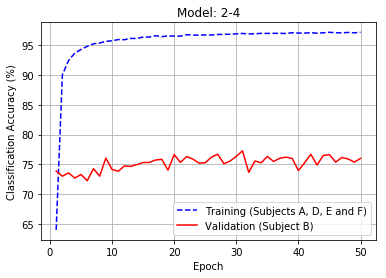

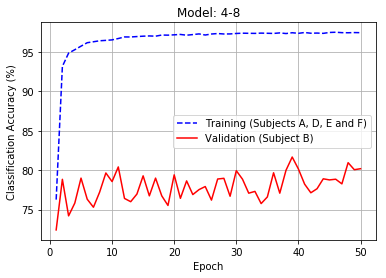

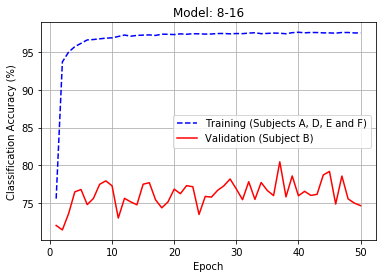

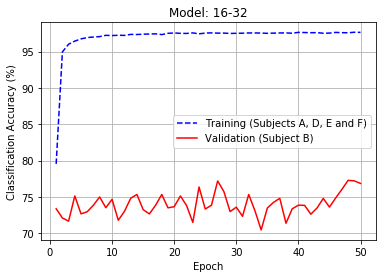

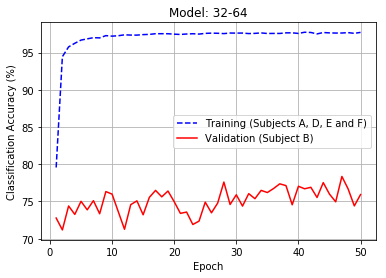

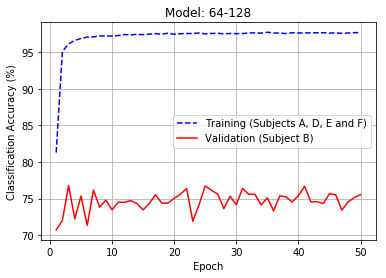

In [14]:
for model_type in model_types:
    training_acc = np.array(overfitting_results[model_type]['acc'])*100
    validation_acc = np.array(overfitting_results[model_type]['val_acc'])*100

    # Create count of the number of epochs
    epoch_count = range(1, len(training_acc) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_acc, 'b--', label='Training (Subjects A, D, E and F)')
    plt.plot(epoch_count, validation_acc, 'r-', label='Validation (Subject B)')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Accuracy (%)')
    plt.title("Model: " + model_type)
    plt.grid()
    if SAVE_GRAPHS_OVERFITTING:
        plt.savefig(RESULTS_PATH + model_type + "_overfitting.pdf", format='pdf')
    plt.show()

## 5-Fold Cross-Validation

### From the above graphs it would seem that all models have almost converged after 30 epochs. Therefore we will use this value for the k-fold comparison.

In [0]:
nb_epoch = 30

### Variables to save results

In [0]:
results = {}
for model_type in model_types:
    results[model_type] = {}
    for user in users:
        results[model_type][user] = {}

### Run K-fold

In [0]:
for model_type in model_types:
    print("Model:", model_type)
    average_accuracy = 0
    average_loss = 0
    for user in users:
        data_split = split_train_validation(user)
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]
        model = make_model(model_type, img_rows, img_cols, nb_classes)

#         model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)
        # train the model using SGD + momentum.
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])

        model.fit(
            train_data,
            train_labels,
            batch_size=batch_size,
            epochs=nb_epoch,
            shuffle=True, 
            verbose=0)
        evaluation = model.evaluate(validation_data, validation_labels,
                                    batch_size=batch_size, verbose=1)
        
        results[model_type][user]["loss"] = evaluation[0]
        results[model_type][user]["accuracy"] = evaluation[1]
        average_loss += evaluation[0]
        average_accuracy += evaluation[1]
        
    results[model_type]["avg_loss"] = average_loss/len(users)
    results[model_type]["avg_acc"] = average_accuracy/len(users)
    print("Average Loss:", average_loss/len(users))
    print("Average Accuracy:", average_accuracy/len(users))

Model: 2-4
7966/7966 [==============================] - 1s 114us/step
Average Loss: 1.4030908718204118
Average Accuracy: 0.4265266270329171
Model: 4-8
7966/7966 [==============================] - 1s 151us/step
Average Loss: 1.396656327857166
Average Accuracy: 0.6836220604025157
Model: 8-16
7966/7966 [==============================] - 2s 192us/step
Average Loss: 1.5095471076534903
Average Accuracy: 0.8336067174380004
Model: 16-32
7966/7966 [==============================] - 2s 296us/step
Average Loss: 2.0561359355134305
Average Accuracy: 0.5301810472284989
Model: 32-64
7966/7966 [==============================] - 3s 433us/step
Average Loss: 1.168295112460761
Average Accuracy: 0.5944569977752386
Model: 64-128
7966/7966 [==============================] - 7s 870us/step
Average Loss: 2.046416935825844
Average Accuracy: 0.5480988646190755


## Save results

In [0]:
if SAVE_RESULTS_K_FOLD:
    with open(RESULTS_PATH + "results_dictionary.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load previous results

In [7]:
with open(RESULTS_PATH + "results_dictionary.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Results Visualization

### Average Accuracy

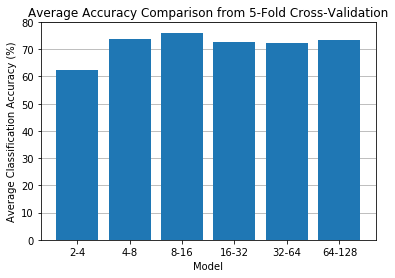

In [43]:
accuracies = []
labels = []
for model_name, value in results.items():
    accuracies.append(value["avg_acc"])
    labels.append(model_name)
    
plt.bar(range(len(labels)), np.array(accuracies)*100, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Model")
plt.ylabel("Average Classification Accuracy (%)")
plt.title("Average Accuracy Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_AVERAGES:
    plt.savefig(RESULTS_PATH + "average_accuracy_comparison.pdf", format='pdf')
plt.show()

### Avererage Loss

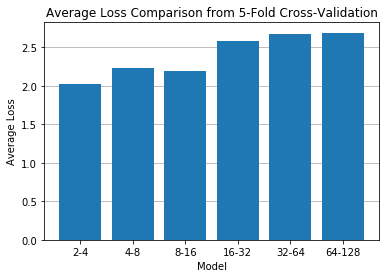

In [44]:
loss = []
labels = []
for model_name, value in results.items():
    loss.append(value["avg_loss"])
    labels.append(model_name)
    
plt.bar(range(len(labels)), loss, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Model")
plt.ylabel("Average Loss")
plt.title("Average Loss Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_AVERAGES:
    plt.savefig(RESULTS_PATH + "average_loss_comparison.pdf", format='pdf')
plt.show()

### Box Plot Comparison

In [8]:
seperated_results = {}
for model_name, value in results.items():
    accuracies = []
    for user_label, res in value.items():
        if len(user_label) > 1:
            continue
        accuracies.append(res["accuracy"] * 100)
    seperated_results[model_name] = accuracies

labels = ["2-4", "4-8", "8-16", "16-32", "32-64", "64-128"]
data_to_plot = []
for label in labels:
    data_to_plot.append(seperated_results[label])

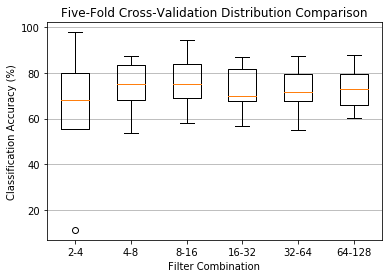

In [10]:
plt.boxplot(data_to_plot, labels=labels, zorder=3)
plt.title("Five-Fold Cross-Validation Distribution Comparison")
plt.xlabel("Filter Combination")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_BOXPLOTS:
     plt.savefig(RESULTS_PATH + "boxplot_all_models.pdf", format='pdf')

All the models above appear to be performing very similiar however due to it's slightly higher mean and specifically it's better minimum performance model "8-16" has been chosen to continue. In the notebook "8_CNN_hyperparameter search.ipynb", a search over the parameter space for this model is conducted.

### Comparing Accuracy Across Folds

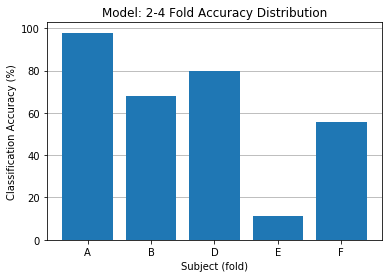

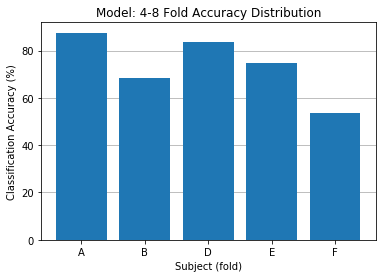

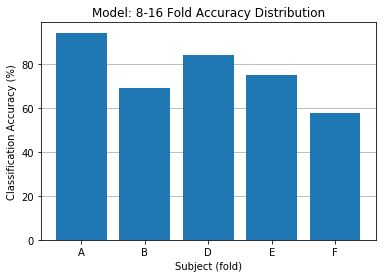

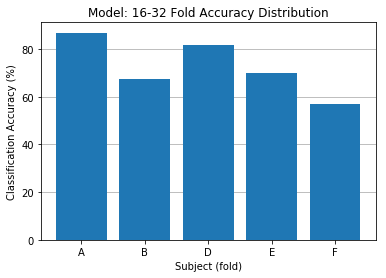

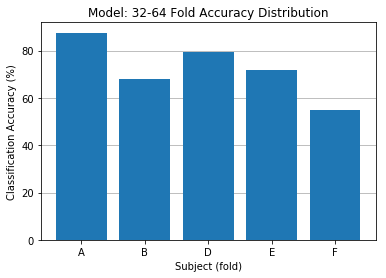

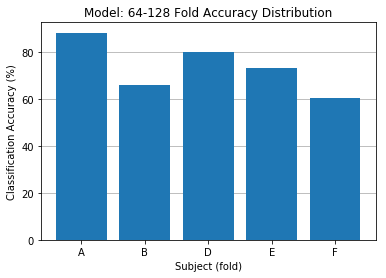

In [47]:
for model_name, value in results.items():
    accuracies = []
    labels = []
    for user_label, res in value.items():
        if len(user_label) > 1:
            continue
        accuracies.append(res["accuracy"]*100)
        labels.append(user_label)
    
    plt.bar(range(len(labels)), accuracies, zorder=3)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel("Subject (fold)")
    plt.ylabel("Classification Accuracy (%)")
    plt.title("Model: " + model_name + " Fold Accuracy Distribution")
    plt.grid(axis='y', zorder=0)
    if SAVE_GRAPHS_DISTRIBUTIONS:
        plt.savefig(RESULTS_PATH + model_name + "_fold_accuracy_distribution.pdf", format='pdf')
    plt.show()

From the graphs above it is interesting that the models followed the same trends over the users.